# Section 06 
### Introduction to Data Science EN.553.436/EN.553.636 - Fall 2021

# 1. Bayesian Parameter Estimation

## Problem 1
Load the following samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X1 = np.array([ 1.62434536, -0.61175641, -0.52817175, -2.07296862,  3.86540763])
X2= np.array([-0.41675785, -0.05626683, -2.1361961 ,  1.64027081, -1.79343559, -0.84174737,  0.50288142, -1.24528809, -1.05795222, -0.90900761])

## 1.1
$X_1$ and $X_2$ are samples from the same distribution.  You are certain that they were collected from a $\mathcal{N}(\mu, \sigma^2 = 1)$ distribution, where $\mu$ is unknown.  Write a Python function that computes the posterior density of $\mu$ given *any* sample; let the prior distribution of $\mu$ be $\mathcal{N}(3, 1)$.

Ensure that your posterior density is in fact a density (which requires that it integrate to 1).  It may be helpful to use np.trapz().

In [3]:
from scipy.stats import norm as gaussian

def prior(mu_array, prior_mu, prior_sigma):
    return gaussian.pdf(mu_array, loc = prior_mu, scale = prior_sigma)

def likelihood(mu_array, sample):
    return np.array([np.prod(gaussian.pdf(sample, loc = mu, scale = 1)) for mu in mu_array])

def posterior(mu_array, sample, prior_mu, prior_sigma, support):
    # evaluates the posterior density of mu
    prior_ = prior(mu_array, prior_mu, prior_sigma)
    likelihood_ = likelihood(mu_array, sample)
    integrand = prior(support, prior_mu, prior_sigma) * likelihood(support, sample)
    normalize = np.trapz(integrand, support)
    posterior_ = (prior_ * likelihood_) / normalize
    return posterior_

## 1.2
What does this prior density suggest our our beliefs regarding $\mu$?  How could we adjust this prior to reflect more/less confident prior beliefs about $\mu$?

In [4]:
#A1: This prior places highest density on mu = 3, suggesting a belief that the mean of the distribution 
#   from which the samples were generated is approximately 3

In [5]:
#A2: If we were less confident in this belief, we'd place less density on mu = 3 in our prior 
#   by increasing the prior variance

## 1.3
Plot the prior distribution of $\mu$, the posterior distribution of $\mu$ given $X1$, and the posterior distribution of $\mu$ given $X1$ and $X2$.

In [6]:
support = np.linspace(-5, 10, 200)

In [7]:
prior_grid = prior(support, 3, 1)
posterior_grid1 = posterior(support, X1, 3, 1, support)
X = np.concatenate([X1, X2])
posterior_grid_full = posterior(support, X, 3, 1, support)

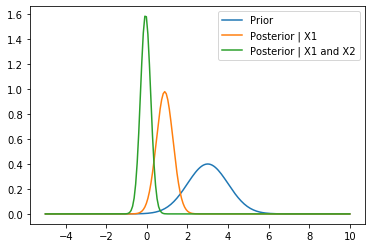

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(support, prior_grid)
ax.plot(support, np.array(posterior_grid1))
ax.plot(support, np.array(posterior_grid_full))
ax.legend(labels=["Prior", "Posterior | X1", "Posterior | X1 and X2"])

## 1.4
Do these plots suggest that our prior beliefs about $\mu$ were (approximately) correct?  Explain.
If not, provide an estimate for $\mu$ based on the posterior density obtained using $X_1$ and $X_2$.

In [9]:
#A: No, as more data is collected, the mode of the posterior distribution decreases noticeably

In [10]:
mle = support[np.argmax(posterior_grid_full)]
mle

-0.10050251256281406

## 1.5
Repeat problem 1.1 (creating a function to compute the posterior density given the sample) and 1.3 (ploting the prior and posterior distributions of $\mu$), except employ the prior $f$ where $f(x) = 1$ for $-2 \leq x \leq -2$ and $f(x) = 0$ otherwise. Also, answer the following:
 1. $f$ isn't a density (i.e., $f$ is an improper prior), but why doesn't that matter?
 2. What beliefs about the the true distribution from which our sample was drawn does this prior encode?  How confident are these beliefs?

In [11]:
#A1: When computing the posterior, we divide by the prior * likelihood by the integral of this
#    quantity over the real line, ensuring that our posterior integrates to one and is in fact a
#    density; this does not require that our prior integrate to 1, though.
#    The prior need not be a density insofar as it reflects our beliefs about
#    the relative probabilities of the possible values of the parameter of interest

#A2: The prior reflects the belief that mu lies in the interval [-2, 2], with each point in this interval being
#    being equally likely.  Since it places 0 probability outside this interval, the prior * likelihood
#    and, thus, the posterior density computed at any point outside this interval will be 0.
#    Thus, this prior reflects the belief with 100% confidence that -2 <= mu <= 2.

In [12]:
def prior2(mu_array):
    return (mu_array >= -2) & (mu_array <= 2)

def likelihood2(mu_array, sample):
    return np.array([np.prod(gaussian.pdf(sample, loc = mu, scale = 1)) for mu in mu_array])

def posterior2(mu_array, sample, support):
    # evaluates the posterior density of mu
    prior_ = prior2(mu_array)
    likelihood_ = likelihood2(mu_array, sample)
    integrand = prior2(support) * likelihood2(support, sample)
    normalize = np.trapz(integrand, support)
    posterior_ = (prior_ * likelihood_) / normalize
    return posterior_

In [13]:
support = np.linspace(-5, 10, 200)
prior_grid2 = prior2(support)
posterior_grid2 = posterior2(support, X1, support)
X = np.concatenate([X1, X2])
posterior_grid_full2 = posterior2(support, X, support)

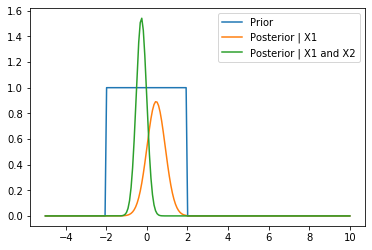

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(support, prior_grid2)
ax.plot(support, np.array(posterior_grid2))
ax.plot(support, np.array(posterior_grid_full2))
ax.legend(labels=["Prior", "Posterior | X1", "Posterior | X1 and X2"])

# 2. Sampling via Metropolis-Hastings
## 2.1
We want to generate a sample $\{\theta_i\}$ of 10000 points from the distribution with density function $f$ such that

$$f(x) \propto x^{2}(1-x)^{5}$$

for $0 \leq x \leq 1$ and $f(x) = 0$ otherwise.  As the generating distribution for $\theta_i$, use $\Gamma(4\theta_{i-1}, \frac{1}{4})$.  To initialize, set $\theta_0 = 0.5$.

In [2]:
from scipy.stats import uniform
from scipy.stats import gamma

In [4]:
theta_0 = .5
m = 10000
samples = [theta_0]

def f(x):
    if x < 0 or x > 1:
        return 0
    else:
        return (x**2)*((1-x)**5)

while len(samples) <= m:
    theta_star = gamma.rvs(size = 1, a = 4*samples[-1], scale = .25)
    alpha = f(theta_star) * gamma.pdf(x = samples[-1], a = 4*theta_star, scale = .25)/ (f(samples[-1]) * gamma.pdf(x = theta_star, a= 4*samples[-1], scale = .25))
    if alpha >= 1:
        samples.append(theta_star[0])
    elif uniform.rvs() < alpha:
        samples.append(theta_star[0])

samples = samples[1:]

In [6]:
theta_star = gamma.rvs(size = 1, a = 4*samples[-1], scale = .25)
theta_star

array([0.7945895])

### 2.2
Plot a density histogram of your sample.  Overlay the histogram with a plot of the true density of $f$ (this requires that you determine the normalizing constant needed to make $f$ a density).

In [17]:
support2 = np.linspace(0,1, 100)
f_array = np.array([f(x) for x in support2])
c = np.trapz(f_array, support2)
density_array = f_array / c

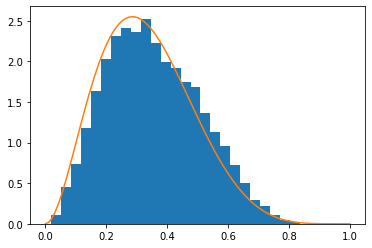

In [18]:
plt.hist(samples, density = True, bins = 25)
plt.plot(support2, density_array)